<h1>Estimating Lifetime Value Using Fader & Hader Retention Models</h1>

The data from below is from an AB test on whether a hypothetical, contractual TV company should offer a 7 day premium free trial for 7 days, as opposed to their current 24 hours premium trial. After the end of the trial period, those who have not cancelled, start their billing cycle and pay for the premium.

This company wants to know which policy would result in a higher customer LTV after 6 months. 

The data we have only goes to the beginning of March 2020, so we need to get a little creative on predicting 6 month LTV.

Fortunately, [Peter Fader and Bruce Hardie](http://brucehardie.com/papers/037/BdW_JIM_2018-01-10_rev.pdf) have shown the usefulness of using a Beta Discrete Weibull model to forecast retention.

My analysis is an example of how this model can be implemented using Python.

In [2]:
import pandas as pd
import numpy as np
from pandasql import sqldf
DATA_PATH = 'https://raw.githubusercontent.com/Truebill/DS2_Challenge/master/tb_datascience_challenge2.csv'

df = pd.read_csv(DATA_PATH)

df['total_premium_time'] = pd.to_datetime(df['premium_cancellation_date']) - pd.to_datetime(df['premium_signup_date'])
df.loc[(df['premium_signup_date'].notnull()), 'signup'] = 1
df.loc[(df['premium_signup_date'].isnull()), 'signup'] = 0

print('duplicated IDs: ' + str(df['user_id'].duplicated().sum()))
print('')
df.head()

duplicated IDs: 0



,is_control,user_id,premium_signup_date,premium_cancellation_date,total_premium_time,signup
0,True,2894666,2020-01-17 17:56:52,2020-01-17 18:01:51,0 days 00:04:59,1.0
1,True,2891900,2020-01-17 15:09:02,2020-01-17 15:15:52,0 days 00:06:50,1.0
2,True,2834881,2020-01-12 23:22:54,NaN,NaT,1.0
3,True,2866240,2020-02-03 01:53:46,NaN,NaT,1.0
4,False,2805370,2020-01-10 20:48:12,2020-01-10 20:55:02,0 days 00:06:50,1.0


In [3]:
df.loc[((df['premium_signup_date'].isnull()) &  (df['is_control'] == 0) ) , 'success'] = 0
df.loc[((df['premium_signup_date'].isnull()) &  (df['is_control'] == 1) ) , 'success'] = 0


df.loc[(df['total_premium_time'] >= '7 days') & (df['is_control'] == 0), 'success'] = 1
df.loc[((df['premium_signup_date'].notnull()) & (df['premium_cancellation_date'].isnull()) & (df['is_control'] == 0) ) , 'success'] = 1
df.loc[((df['total_premium_time'] < '7 days') & (df['is_control'] == 0)) , 'success'] = 0


df.loc[(df['total_premium_time'] >= '1 days') & (df['is_control'] == 1), 'success'] = 1
df.loc[((df['premium_signup_date'].notnull()) & (df['premium_cancellation_date'].isnull()) & (df['is_control'] == 1) ) , 'success'] = 1
df.loc[((df['total_premium_time'] < '1 days') & (df['is_control'] == 1)) , 'success'] = 0

# df.head()
df.head()

,is_control,user_id,premium_signup_date,premium_cancellation_date,total_premium_time,signup,success
0,True,2894666,2020-01-17 17:56:52,2020-01-17 18:01:51,0 days 00:04:59,1.0,0.0
1,True,2891900,2020-01-17 15:09:02,2020-01-17 15:15:52,0 days 00:06:50,1.0,0.0
2,True,2834881,2020-01-12 23:22:54,NaN,NaT,1.0,1.0
3,True,2866240,2020-02-03 01:53:46,NaN,NaT,1.0,1.0
4,False,2805370,2020-01-10 20:48:12,2020-01-10 20:55:02,0 days 00:06:50,1.0,0.0


C:\Users\mccom\Anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\mccom\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\mccom\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

Retention of All Cohorts:



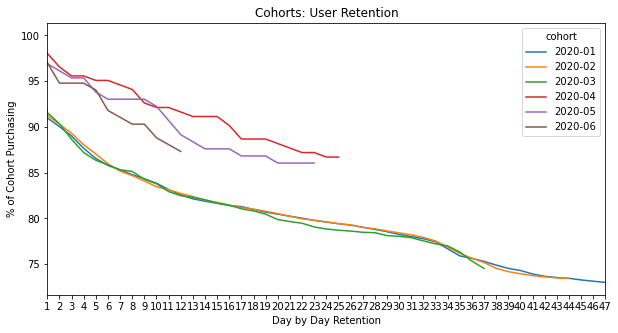

In [4]:
all_signups = df[df['premium_signup_date'].notnull()]

all_signups.loc[(all_signups['premium_signup_date'].notnull()) & (all_signups['premium_cancellation_date'].notnull()), 'churned'] = 1
all_signups.loc[(all_signups['premium_signup_date'].notnull()) & (all_signups['premium_cancellation_date'].isnull()), 'churned'] = 0

allsignups_temp1 = all_signups.groupby(['is_control']).agg({'success': pd.Series.sum}).reset_index()

allsignups_temp2 = all_signups.groupby(['is_control']).agg({'success': pd.Series.count}).reset_index()


prob = allsignups_temp1
prob['success'] = prob['success'] / allsignups_temp2['success'] * 100


all_signups.loc[(all_signups['is_control'] == True), 'is_control'] = 1
all_signups.loc[(all_signups['is_control'] == False), 'is_control'] = 0




all_signups['cohort'] = pd.to_datetime(all_signups['premium_signup_date']).apply(lambda x: x.strftime('%Y-%W'))


con_signups = all_signups[all_signups['is_control'] == 1]
alt_signups = all_signups[all_signups['is_control'] == 0]

all_churns = all_signups[all_signups['churned'] == 1]


all_churns['days_to_churn'] = all_churns.total_premium_time.dt.days



con_churn_base = all_churns[all_churns['is_control'] == 1]
alt_churn_base = all_churns[all_churns['is_control'] == 0]

con_churn = all_churns[all_churns['is_control'] == 1]
alt_churn = all_churns[all_churns['is_control'] == 0]


def cohort_churn(df):
    df['Day_count'] = df['days_to_churn'].apply(lambda x: range(x+1))
    df = df.explode('Day_count').reset_index(drop=True)
    df = df.groupby(['cohort','Day_count']).agg({'user_id': pd.Series.count})
    df = df.rename(columns={"user_id": "Total_customers"})
    return df

all_churns_2 = cohort_churn(all_churns)
alt_churn = cohort_churn(alt_churn)
con_churn = cohort_churn(con_churn)




all_signupsgb = all_signups[all_signups['premium_cancellation_date'].isnull()]
all_signupsgb = all_signupsgb.groupby(['cohort']).agg({'user_id': pd.Series.count})

con_signupsgb = con_signups[con_signups['premium_cancellation_date'].isnull()]
con_signupsgb = con_signupsgb.groupby(['cohort']).agg({'user_id': pd.Series.count})

alt_signupsgb = alt_signups[alt_signups['premium_cancellation_date'].isnull()]
alt_signupsgb = alt_signupsgb.groupby(['cohort']).agg({'user_id': pd.Series.count})





con_churn_2 = con_churn['Total_customers'] + con_signupsgb['user_id']
con_churn_2 = con_churn_2.to_frame().reset_index()
con_churn_2.columns.values[2] = "Total_customers"
con_churn_2 = con_churn_2.groupby(['cohort','Day_count']).agg({"Total_customers":pd.Series.sum})

all_churn_3 = all_churns_2['Total_customers'] + all_signupsgb['user_id']
all_churn_3 = all_churn_3.to_frame().reset_index()
all_churn_3.columns.values[2] = "Total_customers"
all_churn_3 = all_churn_3.groupby(['cohort','Day_count']).agg({"Total_customers":pd.Series.sum})

alt_churn_2 = alt_churn['Total_customers'] + alt_signupsgb['user_id']
alt_churn_2 = alt_churn_2.to_frame().reset_index()
alt_churn_2.columns.values[2] = "Total_customers"
alt_churn_2 = alt_churn_2.groupby(['cohort','Day_count']).agg({"Total_customers":pd.Series.sum})

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

def retention_plotter(df):
    nums = df['Total_customers'].unstack(0)
    cohort_group_size = df['Total_customers'].groupby(level=0).first()
    user_retention = df['Total_customers'].unstack(0).divide(cohort_group_size, axis=1) * 100

    user_retention.plot(figsize=(10,5))
    plt.title('Cohorts: User Retention')
    plt.xticks(np.arange(1, 48, 1))
    plt.xlim(1, 47)
    plt.ylabel('% of Cohort Purchasing')
    plt.xlabel('Day by Day Retention')
    ;

print('Retention of All Cohorts:')
print('')
retention_plotter(all_churn_3)

<h3> Statistical Test</h3>

$H_0$: No relationship between 7-day trials and improved signups

$H_a$: There is a relationship between 7-day trials and improved signups

In [5]:
from scipy.stats import chi2_contingency

print('Contingency table: \n', pd.crosstab(df['is_control'],df['signup']))

# Perform the chi-square test
stat, p_val, dof, expected = chi2_contingency(pd.crosstab(df['is_control'],df['signup']))
print('')
print('Chi2: ' + str(stat))
print('p_val: ' + str(p_val))

Contingency table: 
 signup        0.0    1.0
is_control              
False        3648   2205
True        33480  18132

Chi2: 14.74042510847627
p_val: 0.0001233724638288109


<h3>Is There A Relationship Between Conversions and Group?</h3>


$H_0: No relationship between 7-day trials and conversions 

$H_a: There is a relationship between 7-day trials and conversions 

In [6]:
print('Contingency table: \n', pd.crosstab(all_signups['is_control'],all_signups['success']))

stat, p_val, dof, expected = chi2_contingency(pd.crosstab(all_signups['is_control'],all_signups['success']))
print('')
print('Chi2: ' + str(stat))
print('p_val: ' + str(p_val))

Contingency table: 
 success      0.0    1.0
is_control             
0            345   1860
1           1522  16610

Chi2: 123.14736802960451
p_val: 1.2946684143568947e-28


At all common levels of confidence, we can reject the null hypothesis and conclude that there is  enough evidence to conclude there is a statistically significant relationship between signups to premium membership and your group.

<h3> Is There A Relationship Between Cohort and Churns?</h3>

In [7]:
#Super strong relationship
print('Contingency table: \n', pd.crosstab(all_signups['is_control'],all_signups['churned']))

# Perform the chi-square test
stat, p_val, dof, expected = chi2_contingency(pd.crosstab(all_signups['is_control'],all_signups['churned']))
print('')
print('Chi2: ' + str(stat))
print('p_val: ' + str(p_val))

Contingency table: 
 churned       0.0   1.0
is_control             
0            1533   672
1           13448  4684

Chi2: 21.610411833144703
p_val: 3.3403360743176816e-06


<h3>Retention is better on the Control Group</h3>

At all common levels of significance, we can reject the null and say there is a strong relationship between churns and group.

Retention of the Control Cohort:



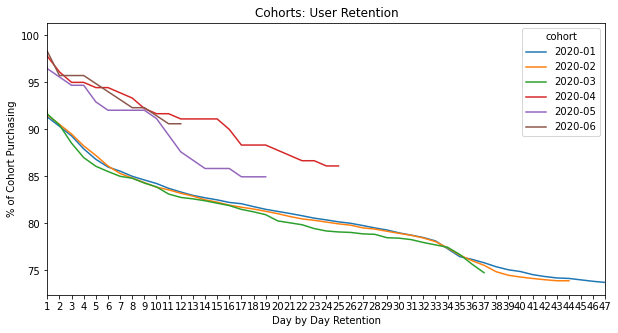

In [8]:
print('Retention of the Control Cohort:')
print('')
retention_plotter(con_churn_2)

Retention of the Testing Cohort:



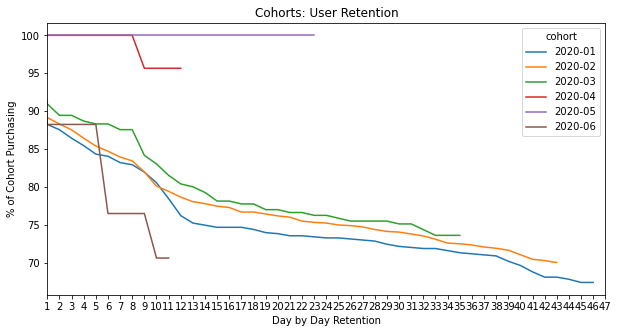

In [9]:
print('Retention of the Testing Cohort:')
print('')
retention_plotter(alt_churn_2)

In [10]:
def retention_plotter_chart(df):
    nums = df['Total_customers'].unstack(0)
    cohort_group_size = df['Total_customers'].groupby(level=0).first()
    user_retention = df['Total_customers'].unstack(0).divide(cohort_group_size, axis=1) * 100
    return user_retention

#removing the last three weeks due to insignificant sample size
retention_alt = retention_plotter_chart(alt_churn_2)
retention_con = retention_plotter_chart(con_churn_2)
retention_con = retention_con.iloc[:,0:3]
retention_alt = retention_alt.iloc[:,0:3]
# retention_con

<h1>Estimating Retention within 6 months</h1>

<h3>Beta  Weibull Predicitions</h3>

Using the Shape parameters provided by the data in each group by their respective cohorts, you can estimate the cohort LTV with a Beta discrete Weibull survival model.

For example, using Cohort 2020-2 in the control group we can get remarkably close to the actual rtention rate of 18 days using just the first 6.

In [11]:
from scipy.optimize import minimize
from scipy.special import beta
import numpy as np
import scipy.special as sc

temp_frame = pd.DataFrame(retention_con.iloc[0:19,1]).reset_index()
surv = np.array(temp_frame['2020-02'][0:6])

# h = x
t = len(surv)
die = np.diff(-surv)
i = np.arange(0,t) 

def dbw_ll(x):
    a = x[0]
    b = x[1]
    c = x[2]
    s = beta(a,b + i**c)/beta(a,b)
    p = np.diff(-s)
    ll_ = die * np.log(p)
    ll = ll_.sum() + surv[-1]*np.log(s[-1])
    return -ll

bnds = [(0.001,10000)]*3

res = minimize(dbw_ll, x0=[1,1,1], 
               method='L-BFGS-B',
               bounds=bnds)
print('Shape Parameters: A, B, C')
print(res.x)

temp_frame['BdW_Predictions'] = (sc.beta(res.x[0], res.x[1] + (temp_frame['Day_count']**res.x[2])) / sc.beta(res.x[0], res.x[1])) * 100

temp_frame

Shape Parameters: A, B, C
[ 4.17374287 45.91387391  0.28359827]


,Day_count,2020-02,BdW_Predictions
0,0,100.000000,100.000000
1,1,91.522684,91.667116
2,2,90.532485,89.972235
3,3,89.501869,88.837177
4,4,88.238860,87.961270
5,5,87.228453,87.239079
6,6,86.106901,86.620044
7,7,85.308679,86.075649
8,8,84.823684,85.588083
9,9,84.338688,85.145414


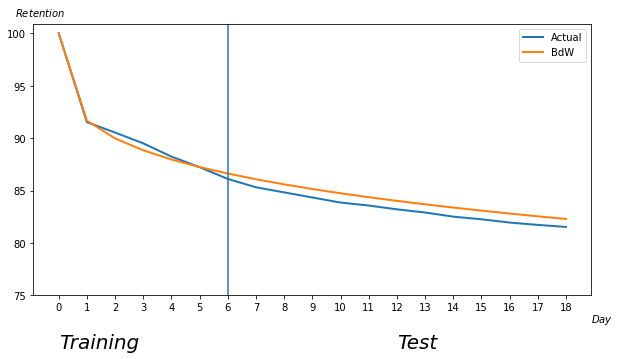

In [12]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon


# a, b = 5, 5  # integral limits
x = temp_frame['Day_count'].astype(str)
y = temp_frame['2020-02']
# y2 = dddd['bg']
y2 = temp_frame['BdW_Predictions']

fig, ax = plt.subplots()
ax.plot(x, y, label = 'Actual',linewidth=2)
# ax.plot(x, y2, label = 'Beta Geometric',linewidth=2)
ax.plot(x, y2, label = 'BdW',linewidth=2)


ax.set_ylim(bottom=75)

plt.axvline(x=6)


ax.text(0, 70, 'Training', style='italic',
        fontsize=20)


ax.text(12, 70, 'Test', style='italic',
        fontsize=20)

fig.text(0.9, 0.05, '$Day$')
fig.text(0.1, 0.9, '$Retention$')

plt.legend()
fig.set_size_inches(10,5)
plt.show()

Using this method of forcasting offers us a more scientifically accurate way to determine the true winner of the A/B test 6 months down the road without having to wait as long.

Should the company offer it’s premium tier for $50/mo, and acquire 50,000 users in March, TV4Free should expect the March Cohort to contributed a 6 month total of:


In [13]:
from scipy.optimize import minimize
from scipy.special import beta
import numpy as np
import scipy.special as sc


def bdw_projection(surv_value,h):
    surv = np.array(surv_value)

    if(surv[0] != 100):
        raise Exception("Starting Value should be 100 or 1")

    t = len(surv)
    die = np.diff(-surv)
    i = np.arange(0,t) 

    def bdw_ll(x):
        a,b,c = x
        s = beta(a,b + i**c)/beta(a,b)
        p = np.diff(-s)
        ll_ = die * np.log(p)
        ll = ll_.sum() + surv[-1]*np.log(s[-1])
        return -ll

    bnds = [(0.001,10000)]*3

    res = minimize(bdw_ll, x0=[1,1,1], 
                    method='L-BFGS-B',
                    bounds=bnds)

    a, b, c = res.x

    bdw_projection = []
    k = 0
    while (sc.beta(res.x[0], res.x[1] + (k**res.x[2])) / sc.beta(res.x[0], res.x[1])):
        while k < h:
            bdw_projection.append((sc.beta(res.x[0], res.x[1] + (k**res.x[2])) / sc.beta(res.x[0], res.x[1]))
)
            k = k + 1
        else:
            break

    return bdw_projection





#For projecting retention for each cohort
con1_bdw_projection = bdw_projection(round(retention_con['2020-01'].dropna()),182)
con2_bdw_projection = bdw_projection(round(retention_con['2020-02'].dropna()),182)
con3_bdw_projection = bdw_projection(round(retention_con['2020-03'].dropna()),182)

BdW_control_projections = pd.DataFrame(
    {'2020-01': con1_bdw_projection,
     '2020-02': con2_bdw_projection,
     '2020-03': con3_bdw_projection
    }).reset_index().rename(columns = {'index': 'Day'})

BdW_control_projections = BdW_control_projections.iloc[[1,31,61,91,121,150,181],:].set_index('Day')
BdW_control_projections

#returning the shape parameters and averaging them out

<ipython-input-13-deebc2a63b58>:19: RuntimeWarning: invalid value encountered in true_divide
  s = beta(a,b + i**c)/beta(a,b)


,2020-01,2020-02,2020-03
Day,,,
1,0.918201,0.925297,0.922584
31,0.770428,0.767307,0.763726
61,0.722736,0.714663,0.711313
91,0.691073,0.679624,0.676511
121,0.666916,0.652904,0.650008
150,0.647826,0.631819,0.629111
181,0.630526,0.612747,0.610222


In [14]:
# BdW_control_projections = BdW_control_projections
# a = round(BdW_control_projections.sum(axis=0),2) * (50000 * 50)
# print('6 Month Control Revenue Projections:')
# a[2]
# # .set_index('Day').groupby(level=0).sum().T
# # .groupby(level=0).sum().T

In [15]:
def bdw_projection(surv_value,h):
    surv = np.array(surv_value)

    if(surv[0] != 100):
        raise Exception("Starting Value should be 100 or 1")

    t = len(surv)
    die = np.diff(-surv)
    i = np.arange(0,t) 

    def bdw_ll(x):
        a,b,c = x
        s = beta(a,b + i**c)/beta(a,b)
        p = np.diff(-s)
        ll_ = die * np.log(p)
        ll = ll_.sum() + surv[-1]*np.log(s[-1])
        return -ll

    bnds = [(0.001,10000)]*3

    res = minimize(bdw_ll, x0=[1,1,1], 
                    method='L-BFGS-B',
                    bounds=bnds)

    a, b, c = res.x

    bdw_projection = []
    k = 0
    while (sc.beta(res.x[0], res.x[1] + (k**res.x[2])) / sc.beta(res.x[0], res.x[1])):
        while k < h:
            bdw_projection.append((sc.beta(res.x[0], res.x[1] + (k**res.x[2])) / sc.beta(res.x[0], res.x[1]))
)
            k = k + 1
        else:
            break

    return bdw_projection





#For projecting retention for each cohort
alt1_bdw_projection = bdw_projection(round(retention_alt['2020-01'].dropna()),188)
alt2_bdw_projection = bdw_projection(round(retention_alt['2020-02'].dropna()),188)
alt3_bdw_projection = bdw_projection(round(retention_alt['2020-03'].dropna()),188)

BdW_alt_projections = pd.DataFrame(
    {'2020-01': alt1_bdw_projection,
     '2020-02': alt2_bdw_projection,
     '2020-03': alt3_bdw_projection
    }).reset_index().rename(columns = {'index': 'Day'})

BdW_alt_projections = BdW_alt_projections.iloc[[7,37,67,97,127,157,187],:].set_index('Day')
BdW_alt_projections

,2020-01,2020-02,2020-03
Day,,,
7,0.805208,0.819038,0.841787
37,0.690300,0.711928,0.736280
67,0.638934,0.663292,0.686945
97,0.604256,0.630130,0.652911
127,0.577803,0.604639,0.626559
157,0.556331,0.583816,0.604924
187,0.538227,0.566165,0.586512


In [16]:
BdW_control_projections = BdW_control_projections
a = round(BdW_control_projections.sum(axis=0),2) * (50000 * 50)
print('6 Month Control Revenue Projections:')
print(a[2])
print('')

BdW_alt_projections = BdW_alt_projections
b = round(BdW_alt_projections.sum(axis=0),2) * (50000 * 50)
print('6 Month Alternative Group Revenue Projections:')
print(b[2])

6 Month Control Revenue Projections:
12400000.0

6 Month Alternative Group Revenue Projections:
11850000.0


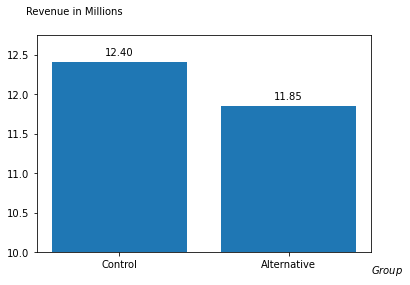

In [45]:
d = {'Group': ['Control','Alternative'], '6 Month Projection': [a[2],b[2]]}
dff = pd.DataFrame(data=d)
dff['6 Month Projection'] = dff['6 Month Projection']/1000000
# dff
fig, ax = plt.subplots()

x_bar = dff['Group']
y_bar = dff['6 Month Projection']
plt.bar(x_bar,y_bar)


for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')



fig.text(0.9, 0.05, '$Group$')
fig.text(0.1, 0.95, 'Revenue in Millions')
ax.set_ylim(bottom=10.00)
ax.set_ylim(top=12.75)
# fig.set_size_inches(10,5)
plt.show()
# # plt.xticks(y_pos, objects)
# # plt.ylabel('Usage')
# # plt.title('Programming language usage')

# plt.show()

<h1>Main Takeaway:</h1>


This company should stick with the control groups premium trial policy as opposed to the alternative. With better retention and LTV, this model is the winner in all respects